This is a demo for visualizing COVID-19 dataset from Johns Hopkins CSSE : https://github.com/CSSEGISandData/COVID-19


In [46]:
from ReadData import ReadData
from DictName import DictName
import urllib3
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import geoplot
import mapclassify

In [ ]:
# Download data from the github repo (data_url) and save to data_path
def download_data(data_path, data_url, verbose=1):
    http = urllib3.PoolManager()
    if verbose > 0:
        print('Downloading data file to ' + data_path + ' ...')
        with http.request('GET', data_url, preload_content=False) as resp, open('./', 'wb') as out:
            shutil.copyfileobj(resp, out)
        out.close()
        print('... done downloading data!')
    

In [6]:
# Download global data from github url
data_path = './git_data/'
data_url_root = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
filetypes = ['confirmed', 'deaths', 'recovered']
downloads = {}

for f in filetypes:
    downloads[f] = data_url_root + 'time_series_covid19_' + f + '_global.csv' 


if not os.path.exists(data_path):
    os.makedirs(data_path)
for f in downloads.keys():
    save_path = data_path + f + '.csv'
    url = downloads[f]
    download_data(data_path, url)

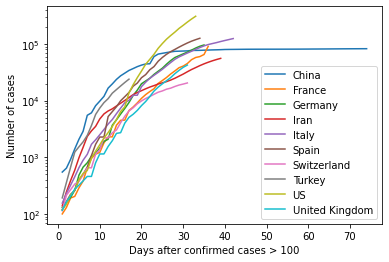

In [47]:
# Read local data

def read_file(read_path):
    d = ReadData(read_path)
    data = d.data
    data_country = data.drop(columns=['Lat', 'Long'])
    data_country =  data_country.groupby('Country/Region', axis=0).sum()
    coordinates = data.loc[:, ['Country/Region', 'Lat', 'Long']]
    data_dict = {'metric': data_country,
                'coordinates': coordinates}

    return data_dict


def plot_time_series(data, fig_params):
    country_list = data.index
    legend_items = []
    fig, axis = plt.subplots()
    for c in country_list:
        y = data.loc[c]        
        y = y[y>=100]
        x = np.array(range(1, len(y)+1))  
        legend_items.append(c)
        axis.plot(x, y)
    axis.legend(legend_items)
    axis.set_xlabel(fig_params['xlabel'])
    axis.set_ylabel(fig_params['ylabel'])
    axis.set_yscale(fig_params['yscale'])



# Store data in dictionary
data_dict = {}
for ft in filetypes:
    path = data_path + ft + '.csv'
    data_dict[ft] = read_file(path)

confirmed = data_dict['confirmed']['metric']

# Plot confirmed cases in countries with confirmed cases > criteria on the last day
fig_params={'xlabel':'Days after confirmed cases > 100',
            'ylabel':'Number of cases',
            'yscale':'log'}
lastday = np.array(confirmed.keys())[-1]
confirmed_to_plot = confirmed[confirmed[lastday]>=20000]

plot_time_series(confirmed_to_plot, fig_params)

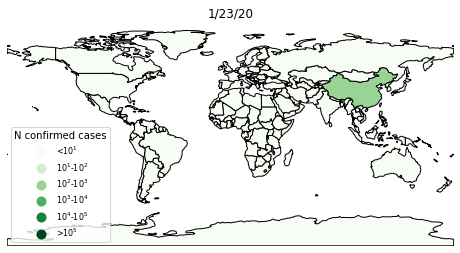

In [44]:
# Calculate countries' daily accumulated confirmed cases and show on world map
def daily_data(data, cgeo, cdata, thisday):
    geo_confirm = np.zeros(cgeo.shape)
    for i, c in enumerate(cgeo):
        if c in cdata:
            case = data.loc[c, thisday]
            
        elif c in DictName.keys():
            # print('found',c, 'in dict') 
            case = data.loc[DictName[c][0], thisday]
        else:
            case = 0

        if case == 0:
            geo_confirm[i] = 0
        else:    
            geo_confirm[i] = np.log10(case)
            # geo_confirm[i] = case
    return geo_confirm

# Get data from geopandas
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
cgeo = np.array(world['name']) # country list from geopandas
cdata = np.array(data_dict['confirmed']['coordinates']['Country/Region'].unique()) # country list from dataset
data = data_dict['confirmed']['metric']
list_dates = np.array(data.keys())
last_day = list_dates[-1]

# use the last day's data as upper and lower limits for coloring polygons
geo_limits = daily_data(data, cgeo, cdata, list_dates[-1])
bins = list(range(1, int(np.ceil(np.max(geo_limits)))))
legend_values = list(range(int(np.ceil(np.max(geo_limits)))))
legend_labels = ['$10^{}$'.format(i)+'-$10^{}$'.format(i+1) for i in legend_values[1:-1]]
legend_labels.insert(0, '<$10^{}$'.format(bins[0]))
legend_labels.append('>$10^{}$'.format(bins[-1]))
for i, day in enumerate(list_dates):
    img_path = './image/%03i'%i + '.png'
    geo_confirm = daily_data(data, cgeo, cdata, day)
    # scheme = mapclassify.EqualInterval(geo_limits, k=6)
    scheme = mapclassify.UserDefined(geo_limits, bins = bins)
    geoplot.choropleth(
        world, hue=geo_confirm, scheme=scheme,
        legend=True, 
        legend_values=legend_values,
        legend_labels=legend_labels,
        legend_kwargs={'loc': 'lower left', 'bbox_to_anchor':(0., 0., 0.1, 0.3),'fontsize':8, 'title':'N confirmed cases',
        },
        cmap='Greens', figsize=(8, 5)
    )
    plt.title(day)
    plt.savefig(img_path)
    if i == 1:
        plt.show()
    else: 
        plt.close()

In [45]:
# under bash use command "convert -delay 10 -loop 0 *.png m.gif"
# show saved .gif
from IPython.display import HTML
HTML('<img src="./image/m.gif">')

Plot new confirmed cases over total confirmed cases over time to show where we are at the exponential increase.
<br/>
Concepts inspired by https://aatishb.com/covidtrends/
<br/>
Pre-assumption: the curve of total confirmed cases over time in most countries is exponential. If we plot new confirmed over total confirmed cases overtime under log scale, we would see it climbing a straight line, until the exponential increase breaks. To overcome noise brought by daily fluctuations of case increase, we use the sum of new cases over a week.


In [70]:
confirmed = data_dict['confirmed']['metric']
lastday = np.array(confirmed.keys())[-1]

# filter out countries that have total confirmed cases > criteria
data_trend = confirmed[confirmed[lastday]>=20000]
country_list = data_trend.index
n_days = data_trend.shape[1]
ncols  = np.arange(0, n_days, 1)
n_past = 7
total0 = data_trend.iloc[:, ncols[:-1*n_past]]
total1 = data_trend.iloc[:, ncols[n_past:]]
delta={}

for c in country_list:
    delta[c] = total1.loc[c].values-total0.loc[c].values
    
max_x = 0
max_y = 0    

for i in range(len(delta[c])):
    fig, axis = plt.subplots()
    
    for ic, c in enumerate(country_list):
        x = total1.loc[c].values
        y = delta[c]
        if y[i] >= 10:
            axis.plot(x[0:i+1], y[0:i+1], label=c, color='gray')
            axis.plot(x[i], y[i], 'bo', markersize=1.50)
            axis.text(x[i], y[i], c)

        max_x = max(max_x, max(x))
        max_y = max(max_y, max(y))
    axis.set_ylabel('New cases over past week')
    axis.set_xlabel('Total cases')
    axis.set_ylim(10, max_y)
    axis.set_xlim(10, max_x)
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.set_title(total1.keys()[i])    
    img_path = './image/trend/%03i'%i + '.png'
    plt.savefig(img_path)
    plt.close()
    # print('img', str(i), 'saved.')

In [72]:
HTML('<img src="./image/trend.gif">')

As shown in the above figure, most countries are still in the process of exponential growth of cases. This figure is useful to get a sense of whether the growth are slowing down, by shifting below the straight line.